# Cybersecurity: Suspicious Web Threat Interactions
### Source: *[Kaggle](https://www.kaggle.com/datasets/jancsg/cybersecurity-suspicious-web-threat-interactions)*
---

## About Dataset
This dataset contains web traffic records collected through AWS CloudWatch, aimed at detecting suspicious activities and potential attack attempts. The data was generated by monitoring traffic to a production web server, using various detection rules to identify anomalous patterns.

## Context
In today's cloud environments, cybersecurity is more crucial than ever. The ability to detect and respond to threats in real time can protect organizations from significant consequences. This dataset provides a view of web traffic that has been labeled as suspicious, offering a valuable resource for developers, data scientists, and security experts to enhance threat detection techniques.

## Dataset Content
Each entry in the dataset represents a stream of traffic to a web server, including the following columns:

`bytes_in`: Bytes received by the server.

`bytes_out`: Bytes sent from the server.

`creation_time`: Timestamp of when the record was created.

`end_time`: Timestamp of when the connection ended.

`src_ip`: Source IP address.

`src_ip_country_code`: Country code of the source IP.

`protocol`: Protocol used in the connection.

`response.code`: HTTP response code.

`dst_port`: Destination port on the server.

`dst_ip`: Destination IP address.

`rule_names`: Name of the rule that identified the traffic as suspicious.

`observation_name`: Observations associated with the traffic.

`source.meta`: Metadata related to the source.

`source.name`: Name of the traffic source.

`time`: Timestamp of the detected event.

`detection_types`: Type of detection applied.

## Approach
This project follows a systematic approach:

> **Baseline Model**: A simple statistical detector using the Interquartile Range (IQR) method establishes the minimum performance threshold. This baseline identifies extreme outliers based on traffic volume (bytes transferred).

> **Advanced Model**: An Isolation Forest algorithm captures multidimensional patterns that the baseline cannot detect, considering multiple features simultaneously (traffic volume, connection duration, time of day, geographic origin).

> **Comparative Analysis**: Both models are evaluated and compared using clustering quality metrics (Silhouette Score) to assess separation between normal and critical threats.

### Imports
---

In [1]:
# System
import os, sys
from pathlib import Path

# Custom scripts
from scripts.kaggle_setup import *
from scripts.df_summary import print_dataframe_summary
from scripts.baseline_model import TrafficAnomalyBaseline

# Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

# Modeling
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, silhouette_samples
import joblib

### Data download
---
!! Kaggle account required for credentials

In [2]:
setup_kaggle_credentials()

✅ kaggle.json already configured


In [3]:
download_link = 'kaggle datasets download -d jancsg/cybersecurity-suspicious-web-threat-interactions -p ./dataset --unzip'
download_data(download_link)

✅ dataset already downloaded


In [4]:
df = pd.read_csv('dataset/CloudWatch_Traffic_Web_Attack.csv')
display(df.head())
print("-" * 80)
print(f"Duplicated rows: {df.duplicated().sum()}")

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


--------------------------------------------------------------------------------
Duplicated rows: 0


### Feature Engineering
---
* From *`time`* feature: *`hour`*

* *`duration_seconds`*: *`end_time` - `creation_time`*

* *`bytes_ratio`*: $\LARGE r = \frac{b_{\text{out}}}{b_{\text{in}} + 1}$

In [5]:
date_cols = ['creation_time', 'end_time', 'time']
for var in date_cols:
    df[var] = pd.to_datetime(df[var])
    
df.columns = df.columns.str.replace('.', '_', regex=False)

df['duration_seconds'] = (df['end_time'] - df['creation_time']).dt.total_seconds()
df['hour'] = df['time'].dt.hour
df['bytes_ratio'] = df['bytes_out'] / (df['bytes_in'] + 1) # +1 to prevent div by 0

display(df[[
    'creation_time', 'end_time', 'duration_seconds', 
    'time', 'hour', 'bytes_ratio'
]].head())

,creation_time,end_time,duration_seconds,time,hour,bytes_ratio
0,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,600.0,2024-04-25 23:00:00+00:00,23,2.318401
1,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,600.0,2024-04-25 23:00:00+00:00,23,0.588296
2,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,600.0,2024-04-25 23:00:00+00:00,23,0.472445
3,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,600.0,2024-04-25 23:00:00+00:00,23,0.467411
4,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,600.0,2024-04-25 23:00:00+00:00,23,2.128390


In [6]:
print_dataframe_summary(df, 'Suspicious Web Threat Interactions')

           COMPREHENSIVE SUMMARY: Suspicious Web Threat Interactions            

────────────────────────────────────────────────────────────────────────────────
📊 BASIC INFORMATION
────────────────────────────────────────────────────────────────────────────────
Shape: 282 rows × 19 columns
Memory Usage: 0.17 MB
Duplicate Rows: 0 (0.00%)

────────────────────────────────────────────────────────────────────────────────
📋 COLUMNS AND DATA TYPES
────────────────────────────────────────────────────────────────────────────────
  • object: 9 column(s)
  • int64: 4 column(s)
  • datetime64[ns, UTC]: 3 column(s)
  • float64: 2 column(s)
  • int32: 1 column(s)

Column List: bytes_in, bytes_out, creation_time, end_time, src_ip, src_ip_country_code, protocol, response_code, dst_port, dst_ip, rule_names, observation_name, source_meta, source_name, time, detection_types, duration_seconds, hour, bytes_ratio

────────────────────────────────────────────────────────────────────────────────
❌ MISSING 

### Data Split
---
~80% train, ~20% test. Dataset too small for validation.

In [7]:
split_date = df['time'].quantile(0.80)

train = df[df['time'] < split_date].copy()
test = df[df['time'] >= split_date].copy()

print(f"Train: {len(train)} rows ({len(train)/len(df)*100:.1f}%)")
print(f"Test:  {len(test)} rows ({len(test)/len(df)*100:.1f}%)")

Train: 217 rows (77.0%)
Test:  65 rows (23.0%)


### Baseline model
---
Baseline model for critical threat detection based on extreme traffic. The model implements a simple statistical anomaly detector using the Interquartile Range (IQR) method. It identifies data points that exceed a calculated threshold based on the distribution of training data. The baseline model establishes the minimum performance threshold that more complex models must exceed.

In [8]:
baseline_model = TrafficAnomalyBaseline()
baseline_model.fit(train)
pred_baseline = baseline_model.predict(test)

print(f"\nDetected anomalies: {pred_baseline.sum()}")

IQR K = 1.5
Features: bytes_in, bytes_out

--------------------------------------------------------------------------------

bytes_in:
  Q1:                  5,602
  Q3:                 31,166
  IQR:                25,564
  Umbral:             69,512 (Q3 + 1.5 * IQR)

bytes_out:
  Q1:                 11,142
  Q3:                 27,096
  IQR:                15,954
  Umbral:             51,027 (Q3 + 1.5 * IQR)

Detected anomalies: 11


### Baseline model scores
The score represents how much a sample violates the thresholds, normalized by IQR for interpretability. Higher scores indicate more extreme anomalies.

In [9]:
scores = baseline_model.get_anomaly_score(test)
test_with_scores = test.copy()
test_with_scores['anomaly_score'] = scores

anomalies_only = test_with_scores[test_with_scores['anomaly_score'] > 0]
print(anomalies_only[['src_ip', 'bytes_in', 'bytes_out', 'anomaly_score']])

             src_ip  bytes_in  bytes_out  anomaly_score
221  165.225.240.79   2007229      59926      75.798662
229   155.91.45.242  18119202    1132321     706.058911
232   155.91.45.242  18187778    1142605     708.741433
245  165.225.240.79   1942449      49030      73.264630
248   155.91.45.242  18231909    1116695     710.467728
255  165.225.240.79   1248666      38254      46.125567
257   155.91.45.242  24326941    1529035     948.890197
258   165.225.209.4     28062      52066       0.065125
264  165.225.240.79   2021960      78684      76.374902
267   155.91.45.242  25199191    1557598     983.010444
279   155.91.45.242  25207794    1561220     983.346972


### Machine Learning: Isolation Forest model
---

### Features tranformation
Features to use:
* bytes_in
* bytes_out
* duration_seconds
* bytes_ratio
* hour
* minutes
* src_ip_country_code

In [10]:
num_features = ['bytes_in', 'bytes_out', 'duration_seconds', 'bytes_ratio', 'hour']
cat_features = ['src_ip_country_code']

train_cat = pd.get_dummies(train[cat_features], prefix='country')
test_cat = pd.get_dummies(test[cat_features], prefix='country')
train_cat, test_cat = train_cat.align(test_cat, join='left', axis=1, fill_value=0)

X_train = pd.concat([
    train[num_features].reset_index(drop=True), 
    train_cat.reset_index(drop=True)
], axis=1)

X_test = pd.concat([
    test[num_features].reset_index(drop=True), 
    test_cat.reset_index(drop=True)
], axis=1)

scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.fit_transform(X_test[num_features])

print(f"X_train shape: {X_train.shape}")
print("-" * 80)
display(X_train.head())

X_train shape: (217, 12)
--------------------------------------------------------------------------------


,bytes_in,bytes_out,duration_seconds,bytes_ratio,hour,country_AE,country_AT,country_CA,country_DE,country_IL,country_NL,country_US
0,-0.289813,-0.283806,0.0,1.071452,1.567106,True,False,False,False,False,False,False
1,-0.281846,-0.257081,0.0,-0.624845,1.567106,False,False,False,False,False,False,True
2,-0.282603,-0.281347,0.0,-0.738432,1.567106,False,False,True,False,False,False,False
3,-0.281961,-0.277181,0.0,-0.743368,1.567106,False,False,False,False,False,False,True
4,-0.289522,-0.279166,0.0,0.885154,1.567106,False,False,False,False,False,True,False


### Isolation Forest model training

In [11]:
iso_model = IsolationForest(
    contamination=0.1,
    n_estimators=100,
    max_samples='auto',
    random_state=42,
    n_jobs=-1
)

iso_model.fit(X_train)

,n_estimators,100
,max_samples,'auto'
,contamination,0.1
,max_features,1.0
,bootstrap,False
,n_jobs,-1
,random_state,42
,verbose,0
,warm_start,False


### Predictions

In [12]:
pred_test = iso_model.predict(X_test)  # -1 = anomaly, 1 = normal
scores_test = iso_model.score_samples(X_test)  # Score (less = more anomalous)

pred_test_binary = (pred_test == -1).astype(int)

print(f"\nDetected anomalies: {pred_test_binary.sum()} ({pred_test_binary.mean():.2%})")


Detected anomalies: 14 (21.54%)


### Save model

In [13]:
model_dir = Path('model')

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    joblib.dump(iso_model, 'model/isolation_forest_model.pkl')
    print('✅ Model saved correctly')
else:
    print(f"ℹ️ {model_dir} directory already created")

ℹ️ model directory already created


### Baseline model vs Isolation Forest
---

In [14]:
concordance = (pred_baseline == pred_test_binary).mean()

print(f"Baseline:          {pred_baseline.sum()} anomalies ({pred_baseline.mean():.2%})")
print(f"Isolation Forest:  {pred_test_binary.sum()} anomalies ({pred_test_binary.mean():.2%})")
print(f"Concordance:       {concordance:.2%}")

test_results = test.copy()
test_results['baseline'] = pred_baseline
test_results['iso_forest'] = pred_test_binary
test_results['iso_score'] = -scores_test

base_only = (pred_baseline == 1) & (pred_test_binary == 0)
iso_only = (pred_baseline == 0) & (pred_test_binary == 1)
both = (pred_baseline == 1) & (pred_test_binary == 1)

print("=" * 70)
print(f"Only baseline detected:            {base_only.sum()}")
print(f"Only Isolation Forest detected:    {iso_only.sum()}")
print(f"Both detected:                     {both.sum()}")

Baseline:          11 anomalies (16.92%)
Isolation Forest:  14 anomalies (21.54%)
Concordance:       92.31%
Only baseline detected:            1
Only Isolation Forest detected:    4
Both detected:                     10


### Anomaly Detection: Baseline vs Isolation Forest
---

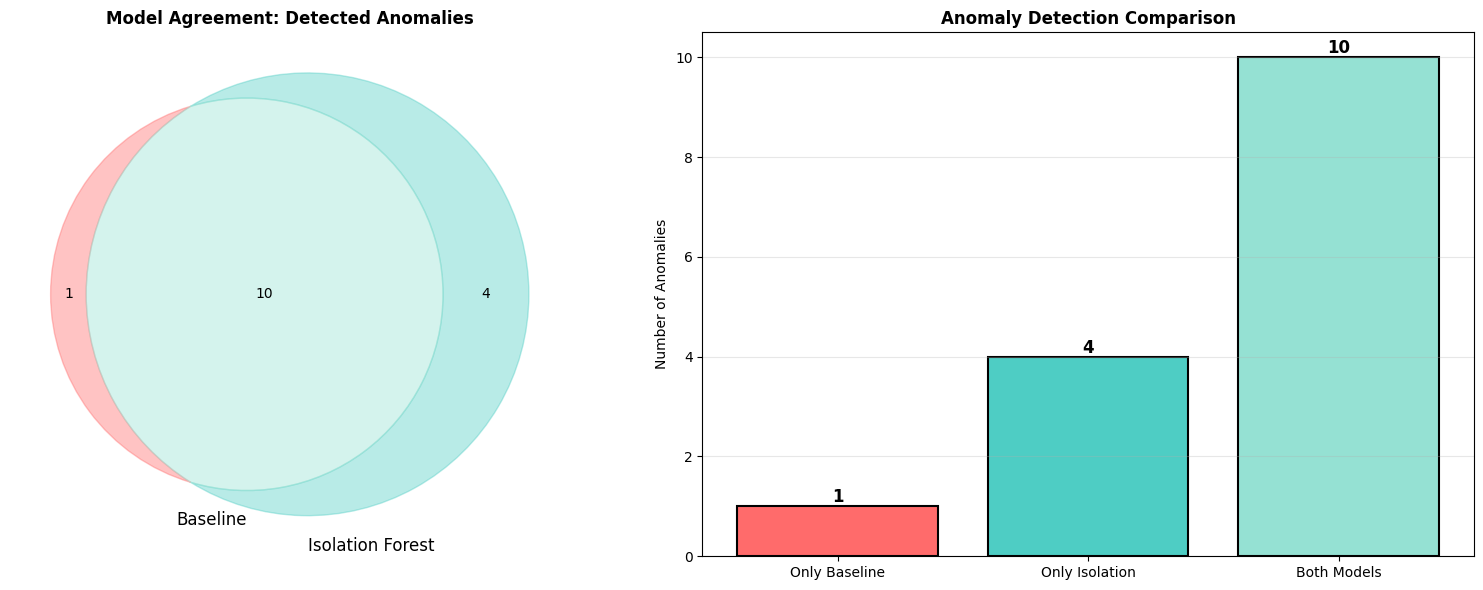

In [15]:
base_only_count = base_only.sum()
iso_only_count = iso_only.sum()
both_count = both.sum()
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

venn = venn2(
    subsets=(base_only_count, iso_only_count, both_count),
    set_labels=('Baseline', 'Isolation Forest'),
    ax=axes[0]
)

venn.get_patch_by_id('10').set_color('#FF6B6B')  # Baseline
venn.get_patch_by_id('01').set_color('#4ECDC4')  # Isolation
venn.get_patch_by_id('11').set_color('#95E1D3')  # Both

axes[0].set_title('Model Agreement: Detected Anomalies', fontweight='bold')

categories = ['Only Baseline', 'Only Isolation', 'Both Models']
counts = [base_only_count, iso_only_count, both_count]
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']

bars = axes[1].bar(categories, counts, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Number of Anomalies')
axes[1].set_title('Anomaly Detection Comparison', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width()/2., height, f'{int(height)}', 
        ha='center', va='bottom', fontsize=12, fontweight='bold'
    )

plt.tight_layout()
plt.show()

There is substantial agreement between both models, with 10 anomalies detected by both approaches (71% of Baseline detections and 71% of Isolation Forest detections).

The Isolation Forest model demonstrates superior detection capability by identifying 4 additional critical threats that the baseline missed, representing a 27% improvement in detection coverage. The baseline uniquely flagged only 1 connection, which may represent either a false positive or an extreme single-feature outlier that Isolation Forest deemed normal within the context.

### Silhouette Score (Isolation Forest)
---

In [16]:
if len(np.unique(pred_test_binary)) > 1:
    silhouette = silhouette_score(X_test, pred_test_binary)
    print(f"\nSilhouette Score: {silhouette:.4f}")
    print("Interpretation:", end=" ")
    if silhouette > 0.5:
        print("Excellent separation")
    elif silhouette > 0.2:
        print("Reasonable separation")
    else:
        print("Weak separation")
else:
    print("\nCannot calculate Silhouette (only 1 class detected)")


Silhouette Score: 0.3720
Interpretation: Reasonable separation


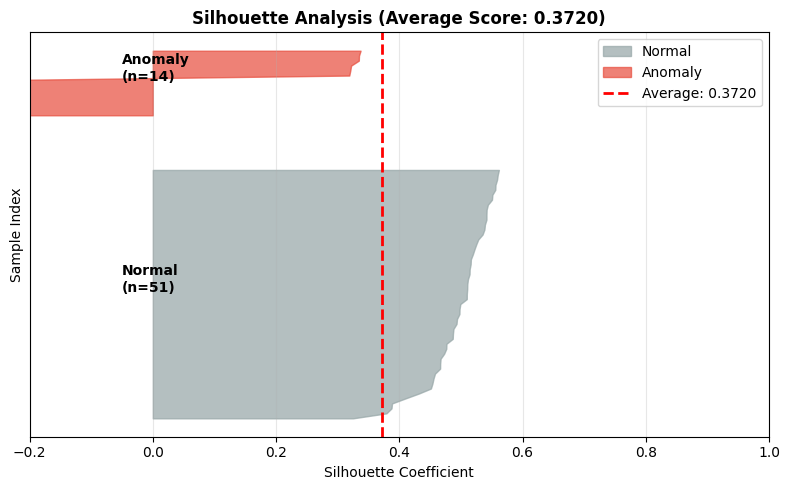

In [17]:
if len(np.unique(pred_test_binary)) > 1:
    silhouette_vals = silhouette_samples(X_test, pred_test_binary)
    silhouette_avg = silhouette_score(X_test, pred_test_binary)
    fig, ax = plt.subplots(figsize=(8, 5))
    y_lower = 10
    for i in [0, 1]:  # 0=normal, 1=anomaly
        cluster_silhouette_vals = silhouette_vals[pred_test_binary == i]
        cluster_silhouette_vals.sort()
        size_cluster = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster
        
        color = '#95A5A6' if i == 0 else '#E74C3C'
        label = 'Normal' if i == 0 else 'Anomaly'
        
        ax.fill_betweenx(
            np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
            facecolor=color, edgecolor=color, alpha=0.7, label=label
        )
        ax.text(
            -0.05, y_lower + 0.5 * size_cluster, f'{label}\n(n={size_cluster})',
            fontsize=10, fontweight='bold'
        )
        
        y_lower = y_upper + 10
    
    ax.set_xlabel('Silhouette Coefficient')
    ax.set_ylabel('Sample Index')
    ax.set_title(f'Silhouette Analysis (Average Score: {silhouette_avg:.4f})', fontweight='bold')
    ax.axvline(x=silhouette_avg, color='red', linestyle='--', linewidth=2, label=f'Average: {silhouette_avg:.4f}')
    ax.set_xlim([-0.2, 1])
    ax.set_yticks([])
    ax.legend(fontsize=10)
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot plot Silhouette (only 1 class)")

The Silhouette Analysis reveals an average score of 0.3720.

**1. Normal traffic cohesion**: The majority of normal samples cluster tightly with predominantly positive silhouette coefficients, indicating well-defined normal behavior patterns.

**2. Anomaly heterogeneity**: The anomaly group shows greater variability in silhouette scores, with several samples near zero or slightly negative. This suggests the detected threats include both:
* **Obvious outliers (high silhouette scores > 0.4)**: Clear statistical anomalies with large deviations.
* **Subtle threats (low silhouette scores < 0.2)**: Sophisticated attacks that blend partially with normal traffic.

### Conclusion
---
The Isolation Forest model successfully surpasses the baseline performance floor, detecting 27% more threats while maintaining reasonable separation quality. The combination of high model agreement (10 shared detections) and additional unique detections (4 by Isolation Forest) suggests that both models provide complementary value: the baseline efficiently catches extreme statistical outliers, while Isolation Forest captures complex multidimensional patterns. For operational deployment, a hybrid approach could be implemented where threats detected by both models receive highest priority, while unique detections from either model warrant secondary investigation.